In [ ]:
# Task 1: Data dimensionality, distance-based classifiers

In [ ]:
from json import load
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Read training and test data, data path is in the parent directory ../dataset/

BASE_DIR = os.getcwd()  # Current working directory (notebook running directory)
DATA_DIR = os.path.abspath(os.path.join(BASE_DIR, "..", "dataset"))

TRAIN_IN_PATH = os.path.join(DATA_DIR, "train_in.csv")
TRAIN_OUT_PATH = os.path.join(DATA_DIR, "train_out.csv")
TEST_IN_PATH = os.path.join(DATA_DIR, "test_in.csv")
TEST_OUT_PATH = os.path.join(DATA_DIR, "test_out.csv")


def load_data():
    X_train = pd.read_csv(TRAIN_IN_PATH, header=None).values
    y_train = pd.read_csv(TRAIN_OUT_PATH, header=None).values.ravel()
    X_test = pd.read_csv(TEST_IN_PATH, header=None).values
    y_test = pd.read_csv(TEST_OUT_PATH, header=None).values.ravel().astype(int)
    assert (
        X_train.shape[1] == 256
    ), f"Expected feature dimension 256, got {X_train.shape[1]}"
    assert (
        y_train.shape[0] == X_train.shape[0]
    ), f"y_train sample size should match X_train, got y_train: {y_train.shape[0]}, X_train: {X_train.shape[0]}"
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_data()
print(
    f"x train data shape: {X_train.shape}, test data shape: {X_test.shape}",
    flush=True,
)
print(
    f"y train data shape: {y_train.shape}, test data shape: {y_test.shape}",
    flush=True,
)

x train data shape: (1707, 256), test data shape: (1000, 256)
y train data shape: (1707,), test data shape: (1000,)


In [ ]:
# 1) Compute digit centers and pairwise center distance matrix

import numpy as np


def compute_digit_centers(X, y, num_classes):
    centers = {}
    for d in range(num_classes):
        indices = []
        for i in range(len(y)):
            if y[i] == d:
                indices.append(i)
        # Get all samples belonging to class d
        X_digit = X[indices]
        # Compute the mean vector for this class
        centers[d] = X_digit.mean(axis=0)
    return centers


def pair_center_distances(centers):
    # centers: shape (n, d), n is number of classes, d is feature dimension
    n = centers.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # Compute Euclidean distance between center i and center j
            D[i, j] = np.sqrt(np.sum((centers[i] - centers[j]) ** 2))
    return D


def sort_pair(pair_distances):
    pairs_sorted = []
    for pair in pair_distances:
        pairs_sorted.append(pair)
    # Sort by distance (the second element of the tuple)
    for i in range(len(pairs_sorted)):
        for j in range(i + 1, len(pairs_sorted)):
            if pairs_sorted[i][1] > pairs_sorted[j][1]:
                pairs_sorted[i], pairs_sorted[j] = pairs_sorted[j], pairs_sorted[i]
    return pairs_sorted


digit_num = len(np.unique(y_train))
print(f"Detected {digit_num} digit classes.")

centers = compute_digit_centers(X_train, y_train, num_classes=digit_num)
print("Each digit center shape:", centers[0].shape)

centers = np.stack([centers[d] for d in range(digit_num)], axis=0)  # (10,256)
assert centers.shape == (
    10,
    256,
), f"Expected centers shape (10,256), got {centers.shape}"

D = pair_center_distances(centers)
assert D.shape == (10, 10), f"Expected distance matrix shape (10,10), got {D.shape}"

pair_distances = [
    ((i, j), D[i, j]) for i in range(digit_num) for j in range(i + 1, digit_num)
]
pairs_sorted = sort_pair(pair_distances)

print("Top 3 closest pairs of class centers and their distances:", flush=True)

for (i, j), dist in pairs_sorted[:3]:
    print(f"  ({i}, {j}): {dist:.4f}")
likely_hard_pairs = [(i, j) for (i, j), _ in pairs_sorted[:3]]

Detected 10 digit classes.
Each digit center shape: (256,)
Top 3 closest pairs of class centers and their distances:
  (7, 9): 5.4265
  (4, 9): 6.0104
  (3, 5): 6.1188


Dimensionality reduction visualization (training set)...


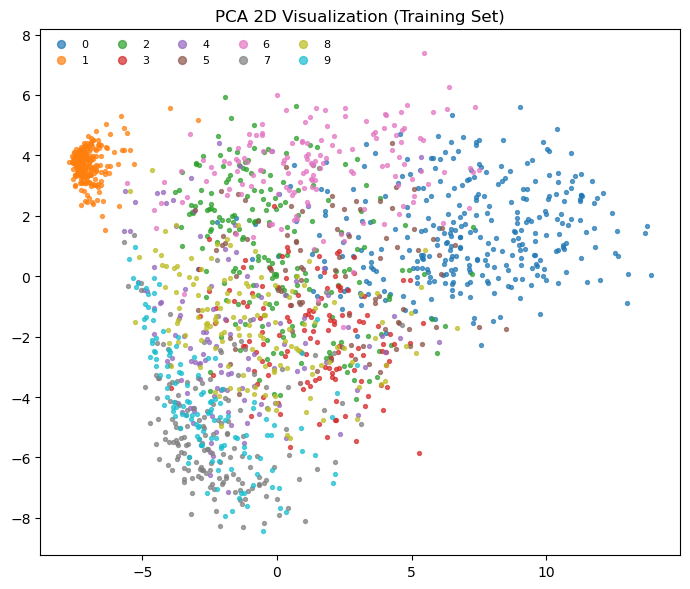

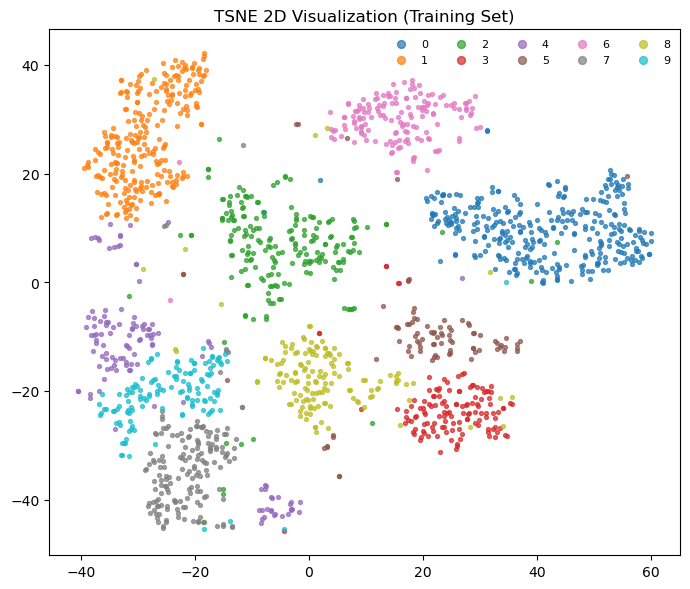

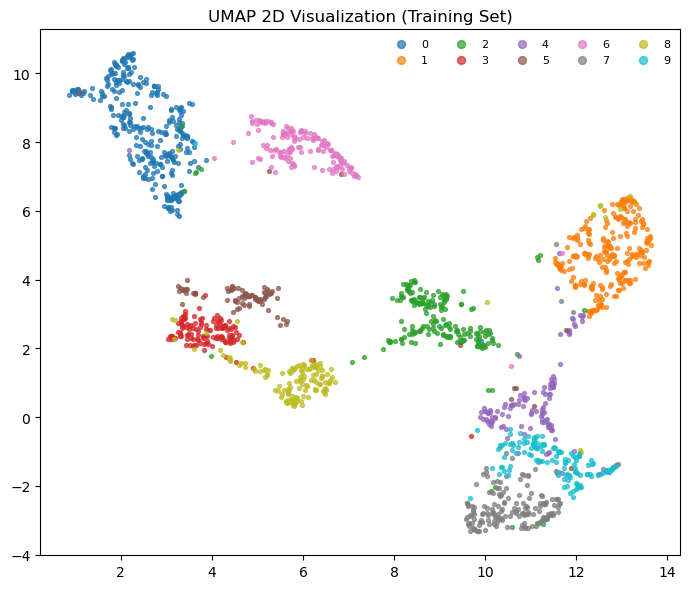

In [ ]:
%pip install ipywidgets

# 2) Dimensionality reduction visualization (training set)

print("Dimensionality reduction visualization (training set)...")


def visualize_2d(method_name, X, y, random_state=42):
    if method_name == "PCA":
        Z = PCA(n_components=2, random_state=random_state).fit_transform(X)
    elif method_name == "TSNE":
        Z = TSNE(
            n_components=2, random_state=random_state, init="pca", learning_rate="auto"
        ).fit_transform(X)
    elif method_name == "UMAP":
        reducer = umap.UMAP(n_components=2)
        Z = reducer.fit_transform(X)
    else:
        raise ValueError("Unknown method")

    fig, axes = plt.subplots(1, 1, figsize=(7, 6))
    fig.tight_layout(pad=4.0)

    # 定义颜色调色板
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    for d in range(10):
        axes.scatter(
            Z[y == d, 0], Z[y == d, 1], s=8, c=[colors[d]], label=str(d), alpha=0.7
        )
    axes.legend(markerscale=2, fontsize=8, ncol=5, frameon=False)
    axes.set_title(f"{method_name} 2D Visualization (Training Set)")
    fig.tight_layout()

    plt.show()
    plt.close(fig)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

visualize_2d("PCA", X_train, y_train)
visualize_2d("TSNE", X_train, y_train)
visualize_2d("UMAP", X_train, y_train)

In [ ]:
# 3) Implement Nearest Mean Classifier
def nearest_mean_predict(X, centers):
    print(f"X shape: {X.shape}, centers shape: {centers.shape}")

    assert (
        X.shape[1] == centers.shape[1]
    ), f"Feature dimension of X ({X.shape[1]}) does not match that of centers ({centers.shape[1]}), please check your input."

    preds = []
    # For each sample x in X (each x is a 256-dimensional vector), compute the Euclidean distance to each center (also 256-dimensional), and return the index of the closest center
    for i in range(X.shape[0]):
        x = X[i]  # Extract the i-th sample, a 256-dimensional vector
        min_dist = float("inf")
        min_idx = -1
        for j in range(centers.shape[0]):
            # Extract the j-th center, a 256-dimensional vector
            center = centers[j]
            dist = np.linalg.norm(x - center)  # Compute Euclidean distance
            if dist < min_dist:
                min_dist = dist
                min_idx = j
        preds.append(min_idx)

    return np.array(preds)


print("Implementing Nearest Mean Classifier...")
y_pred_train_nmc = nearest_mean_predict(X_train, centers)
y_pred_test_nmc = nearest_mean_predict(X_test, centers)

acc_train_nmc = np.mean(y_train == y_pred_train_nmc)
acc_test_nmc = np.mean(y_test == y_pred_test_nmc)
print(f"Nearest Mean Classifier training accuracy: {acc_train_nmc:.4f}", flush=True)
print(f"Nearest Mean Classifier test accuracy: {acc_test_nmc:.4f}", flush=True)

Implementing Nearest Mean Classifier...
X shape: (1707, 256), centers shape: (10, 256)
X shape: (1000, 256), centers shape: (10, 256)
Nearest Mean Classifier training accuracy: 0.8635
Nearest Mean Classifier test accuracy: 0.8040


In [17]:
# 4) KNN classifier
from sklearn.neighbors import KNeighborsClassifier

print("Training and evaluating KNN classifier (k=5, Euclidean)...", flush=True)
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean", weights="uniform")
knn.fit(X_train, y_train)
y_pred_train_knn = knn.predict(X_train)
y_pred_test_knn = knn.predict(X_test)
acc_train_knn = np.mean(y_train == y_pred_train_knn)
acc_test_knn = np.mean(y_test == y_pred_test_knn)
print(f"KNN training accuracy: {acc_train_knn:.4f}", flush=True)
print(f"KNN test accuracy: {acc_test_knn:.4f}", flush=True)

Training and evaluating KNN classifier (k=5, Euclidean)...
KNN training accuracy: 0.9660
KNN test accuracy: 0.9080


In [19]:
# 5) Generate confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score

cm_train_nmc = confusion_matrix(y_train, y_pred_train_nmc, labels=list(range(10)))
cm_test_nmc = confusion_matrix(y_test, y_pred_test_nmc, labels=list(range(10)))

cm_train_knn = confusion_matrix(y_train, y_pred_train_knn, labels=list(range(10)))
cm_test_knn = confusion_matrix(y_test, y_pred_test_knn, labels=list(range(10)))

print("\n—— Conclusions and Observations ——")
print(f"Nearest Mean Classifier: Train {acc_train_nmc:.4f}, Test {acc_test_nmc:.4f}")
print(f"KNN (k=5): Train {acc_train_knn:.4f}, Test {acc_test_knn:.4f}")
print(
    "Digit pairs that are likely hard to distinguish (based on smallest center distances):",
    likely_hard_pairs,
)
print("\nNMC Training Set Confusion Matrix:")
print(cm_train_nmc)
print("\nNMC Test Set Confusion Matrix:")
print(cm_test_nmc)
print("\nKNN Training Set Confusion Matrix:")
print(cm_train_knn)
print("\nKNN Test Set Confusion Matrix:")
print(cm_test_knn)


—— Conclusions and Observations ——
Nearest Mean Classifier: Train 0.8635, Test 0.8040
KNN (k=5): Train 0.9660, Test 0.9080
Digit pairs that are likely hard to distinguish (based on smallest center distances): [(7, 9), (4, 9), (3, 5)]

NMC Training Set Confusion Matrix:
[[271   0   0   0   2   4  36   0   6   0]
 [  0 252   0   0   0   0   0   0   0   0]
 [  3   0 167   9   9   1   3   4   6   0]
 [  0   0   2 120   1   3   0   1   3   1]
 [  0   8   1   0  95   0   3   0   0  15]
 [  3   0   2   3   4  67   3   1   2   3]
 [ 10   4   5   0   2   0 129   0   1   0]
 [  0   4   0   0   2   2   0 140   1  17]
 [  1   2   1  10   2   3   1   0 121   3]
 [  0   3   0   1  10   0   0   6   0 112]]

NMC Test Set Confusion Matrix:
[[178   0   3   2   4   2  23   1  10   1]
 [  0 120   0   0   0   0   1   0   0   0]
 [  2   0  69   6   8   1   0   2  13   0]
 [  3   0   3  61   1   8   0   0   1   2]
 [  1   3   3   0  69   0   1   1   0   8]
 [  3   0   0   6   3  38   1   0   0   4]
 [  7   